# PyTorch Lab 3

Written by Prachya Boonkwan (Arm)

In [0]:
!pip install -q torch torchvision tqdm nltk
import nltk
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Sequence Prediction

In this workshop, we are going to implement a word tokenizer based on recurrent neural networks.

We will apply sequence prediction to word segmentation. We are now going to simulate the problem in English by removing all spaces in English and pretending that it is a consecutively written language. For example, a sentence like

`Hi there. My name is Arm.`

would be converted into a string similar to below:

`hithere.mynameisarm.`

Then we will tokenize this string with a deep neural network model and compare the result with the original string.

## Header

This part is the header of the code. My favorite import aliases for PyTorch are as follows. This will be very useful for speed coding.

In [0]:
#!/usr/bin/env python3
#-*- coding: utf-8 -*-

import torch as T
import torch.nn as N
import torch.optim as O

from tqdm import tqdm    # Nice progressbar
import matplotlib.pyplot as plt
%matplotlib inline

import random

-----

## Data Preparation

### Using Free Dataset from The Gutenberg Project 

We will download a sample text from NLTK (natural language toolkit) and make it our dataset (a.k.a. *corpus*). Here we choose 'The Hamlet' of Shakespeare, a classic English novel from the 16th century. We convert every word into the lower case (e.g. `Hello` -> `hello`).

Note that this dataset is textual, not numerical. We will have to convert it into a bunch of numbers so that it can be processed by the neural networks.

In [0]:
from nltk.corpus import gutenberg

corpus = [ [word.lower() for word in sent]
           for sent in gutenberg.sents('shakespeare-hamlet.txt') ]

crplen = len(corpus)
print('Number of sentences = {}'.format(crplen))

no_words = sum(len(sent) for sent in corpus)
print('Number of words     = {}'.format(no_words))

Number of sentences = 3106
Number of words     = 37360


### Character Indexing

Once we obtain the dataset, we will now convert it into sequences of numbers. Our objective is to convert a string e.g. `hello` into a vector of five numbers representing each character. Such numbers are called *character indices*.

We first populate all characters in the dataset into `all_chars`.

In [0]:
all_chars = set()
for sent in corpus:
    for word in sent:
        all_chars.update(set(word))

Then we create a mapping table from an index to a corresponding character. Let's name this table `idx2char`.

In [0]:
idx2char = [None] + sorted(all_chars)
print(idx2char)

no_chars = len(idx2char)
print('Number of characters = {}'.format(no_chars))

[None, '!', '&', "'", '(', ')', ',', '-', '.', '1', '5', '9', ':', ';', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of characters = 43


Next we create another table that maps each character back to its corresponding index. Let's name this table `char2idx`.

In [0]:
char2idx = {}
for (idx, char) in enumerate(idx2char):
    char2idx[char] = idx
print(char2idx)

{None: 0, '!': 1, '&': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '1': 9, '5': 10, '9': 11, ':': 12, ';': 13, '?': 14, '[': 15, ']': 16, 'a': 17, 'b': 18, 'c': 19, 'd': 20, 'e': 21, 'f': 22, 'g': 23, 'h': 24, 'i': 25, 'j': 26, 'k': 27, 'l': 28, 'm': 29, 'n': 30, 'o': 31, 'p': 32, 'q': 33, 'r': 34, 's': 35, 't': 36, 'u': 37, 'v': 38, 'w': 39, 'x': 40, 'y': 41, 'z': 42}


Note that we deliberately add `None` as one of the characters. It will be used for finding an unknown/unseen character to an index by mapping it to `None`.

### Conversion between String and Index Sequence

It is now very easy to convert a character sequence into a sequence of character index. Here we sequentially convert each character in the sequence into its corresponding index.

In [0]:
def str2idxseq(charseq):
    idxseq = []
    for char in charseq:
        char = char.lower()
        if char in char2idx:
            idxseq.append(char2idx[char])
        else:
            idxseq.append(char2idx[None])
    return idxseq

In [0]:
cuter_idxseq = str2idxseq('CutEr')
print(cuter_idxseq)

[19, 37, 36, 21, 34]


Also, we can sequentially convert a sequence of character indices back to a character sequence. Note that any unknown character index will be converted to a space.

In [0]:
def idxseq2str(idxseq):
    charseq = []
    for idx in idxseq:
        if idx < len(idx2char):
            charseq.append(idx2char[idx])
        else:
            charseq.append(' ')
    return charseq

In [0]:
print(idxseq2str(cuter_idxseq))

['c', 'u', 't', 'e', 'r']


### Preparing Training and Testing Sets

Now it's time to prepare our dataset for the neural networks. We will convert a sequence of words into a representation containing a sequence of character indices and a sequence of word delimiters. For example, the list `['my', 'name']` will be converted into:

- A sequence of character indices [`m`, `y`, `n`, `a`, `m`, `e`]
- A sequence of word delimiters $[\mathbb{F}, \mathbb{T}, \mathbb{F}, \mathbb{F}, \mathbb{F}, \mathbb{T}]$

| m | y | n | a | m | e |
|:-:|:-:|:-:|:-:|:-:|:-:|
| F | T | F | F | F | T |

In [0]:
def sent2data(sent):
    charidxs = []
    wordbrks = []
    for charseq in sent:
        idxs = str2idxseq(charseq)
        charidxs.extend(idxs)
        wordbrks.extend((len(idxs) - 1) * [False] + [True])
    return (charidxs, wordbrks)

Let's try it out with the list `['hello', 'world']`.

In [0]:
sent = ['hello', 'world']
charidxs, wordbrks = sent2data(sent)
print(charidxs)
print(wordbrks)

[24, 21, 28, 28, 31, 39, 31, 34, 28, 20]
[False, False, False, False, True, False, False, False, False, True]


Then we convert the whole dataset into this representation.

In [0]:
def corpus2dataset(corpus):
    dataset = []
    for sent in corpus:
        charidxs, wordbrks = sent2data(sent)
        dataset.append((charidxs, wordbrks))
    return dataset

In [0]:
crp = [ ['hello', 'world'],
        ['my', 'name', 'is', 'arm'] ]
ds = corpus2dataset(crp)
print(ds)

[([24, 21, 28, 28, 31, 39, 31, 34, 28, 20], [False, False, False, False, True, False, False, False, False, True]), ([29, 41, 30, 17, 29, 21, 25, 35, 17, 34, 29], [False, True, False, False, False, True, False, True, False, False, True])]


FInally, we separate the dataset into two parts: the training set (80%), and the testing set (20%).

In [0]:
training_len = int(crplen * 0.8)           # 80% for training, 20% for testing
training_set = corpus2dataset(corpus[: training_len])
testing_set = corpus2dataset(corpus[training_len :])
print('Size of training set = {}'.format(len(training_set)))
print('Size of testing set = {}'.format(len(testing_set)))

Size of training set = 2484
Size of testing set = 622


-----

### Common Settings

In [0]:
dim_charvec = 10
dim_trans = 5
no_rnn_layers = 1

-------

## Embedding Layer

Embedding layer is used for mapping any sparse item, such as characters, words, and any symbols, into a vector. This vector is sometimes called *embedding vector*. The command `N.Embedding` creates an embedding layer containing a specified number of sparse items and their embedding vectors contain a specified number of elements. 

In [0]:
charemb_layer = N.Embedding(no_chars, dim_charvec)
print(charemb_layer)

Embedding(43, 10)


This is how we compute an embedding vector of each character in a string.

In [0]:
charseq = 'hello'

charidxs = str2idxseq(charseq)
print('Index sequence of "{}" is {}\n'.format(charseq, charidxs))

charvecs = charemb_layer(T.LongTensor(charidxs))
print('Embedding vectors for each character:\n{}'.format(charvecs))

Index sequence of "hello" is [24, 21, 28, 28, 31]

Embedding vectors for each character:
tensor([[ 1.3507, -0.4437, -0.3860, -0.8155, -0.3321,  0.1039,  0.1480, -0.2776,
          1.6632,  1.6283],
        [-0.0226,  0.6330,  0.9687,  1.0236, -0.0603, -1.2780,  0.2938, -0.6008,
          0.5145,  1.3794],
        [-0.9798, -0.1157,  0.6120, -0.5613,  0.0252,  0.0742,  0.5543, -0.1895,
         -1.9382, -1.2358],
        [-0.9798, -0.1157,  0.6120, -0.5613,  0.0252,  0.0742,  0.5543, -0.1895,
         -1.9382, -1.2358],
        [-0.5508, -0.8740,  0.1747, -0.1624, -0.5439,  0.0976, -0.7356,  0.2648,
         -1.5961,  0.8870]], grad_fn=<EmbeddingBackward>)


Note that the embedding vector of two `l`'s are the same.

Although the result is a matrix, we can easily get access to each embedding vector by matrix indexing `[]`.

In [0]:
for i in range(len(charseq)):
    print('Character embedding for index {} "{}" is:\n{}'.format(i, charseq[i], charvecs[i]))

Character embedding for index 0 "h" is:
tensor([ 1.3507, -0.4437, -0.3860, -0.8155, -0.3321,  0.1039,  0.1480, -0.2776,
         1.6632,  1.6283], grad_fn=<SelectBackward>)
Character embedding for index 1 "e" is:
tensor([-0.0226,  0.6330,  0.9687,  1.0236, -0.0603, -1.2780,  0.2938, -0.6008,
         0.5145,  1.3794], grad_fn=<SelectBackward>)
Character embedding for index 2 "l" is:
tensor([-0.9798, -0.1157,  0.6120, -0.5613,  0.0252,  0.0742,  0.5543, -0.1895,
        -1.9382, -1.2358], grad_fn=<SelectBackward>)
Character embedding for index 3 "l" is:
tensor([-0.9798, -0.1157,  0.6120, -0.5613,  0.0252,  0.0742,  0.5543, -0.1895,
        -1.9382, -1.2358], grad_fn=<SelectBackward>)
Character embedding for index 4 "o" is:
tensor([-0.5508, -0.8740,  0.1747, -0.1624, -0.5439,  0.0976, -0.7356,  0.2648,
        -1.5961,  0.8870], grad_fn=<SelectBackward>)


-----

## Recurrent Neural Networks

A recurrent neural network (RNN) is a neural network that takes its internal state as an input of the next feed-forwarding. Doing so enables the neural network to capture long-range dependency of any input sequence, making sequence prediction possible.

RNNs linearly sweep across an input sequence of vectors to produce context vectors. This allows RNNs to accept input sequences of variable lengths during each training session. However, it is a bit harder to run batch training, because the lengths of input sequences are not equal.

In this workshop, we will therefore focus on online training, i.e. feeding one training datum and perform backpropagation at a time. We will come back to batch training of RNNs in Lab 5.

### Common Parameters

In [0]:
dim_charvec = 10
dim_trans = 5
no_rnn_layers = 1

### Unidirectional RNNs

The simplest form of RNNs is a unidirectional RNN. It takes a sequence of sparse items as an input, sweeps from left to right, performs feed-forwarding, and produces two outputs:

1. The context vector for each step of feed-forwarding
2. The last internal state vector of the RNN's cell

In this example, we choose Gated Recurrent Unit (GRU) `N.GRU`. You can also replace it with Long Short-Term Memories (LSTM) `N.LSTM`. They are almost the same, but the first converges a bit faster.

In [0]:
rnn_unidir = N.GRU(dim_charvec, dim_trans, no_rnn_layers, batch_first=True)
print(rnn_unidir)

GRU(10, 5, batch_first=True)


Here we set `batch_first=True` because we want the first dimension (`dim=0`) to become the batch ID. For ease of understanding, we will feed a sequence input vectors as a single mini-batch in this workshop.

To perform sequence learning, we first convert a sequence of character embedding vectors into a single mini-batch with the command `unsqueeze(0)`.

Then we pass this mini-batch into an RNN. It will produce two outputs:

1. The context vectors of each step of feed-forwarding
2. The last internal state vector of the RNN's cell

Once we obtain the outputs, we finally remove the mini-batch by the command `squeeze(0)`, which eliminates the mini-batch dimension from the obtained tensor.

In [0]:
ctxvecs_unidir, lasthids_unidir = rnn_unidir(charvecs.unsqueeze(0))
ctxvecs_unidir, lasthids_unidir = ctxvecs_unidir.squeeze(0), lasthids_unidir.squeeze(1)
print(ctxvecs_unidir)
print(lasthids_unidir)

tensor([[-0.2847,  0.0535,  0.1816, -0.0720, -0.2713],
        [-0.4444,  0.2203,  0.2559,  0.3473,  0.2781],
        [-0.3983,  0.6929,  0.0815,  0.0902,  0.2487],
        [-0.3369,  0.8325, -0.0446, -0.1193,  0.2016],
        [-0.1563,  0.6219, -0.0959, -0.2301,  0.0338]],
       grad_fn=<SqueezeBackward1>)
tensor([[-0.1563,  0.6219, -0.0959, -0.2301,  0.0338]], grad_fn=<SqueezeBackward1>)


### Bidirectional RNNs

We can sweep the input sequence from both directions and perform feed-forwarding separately. Just specify the argument `bidirection=True` in the command `N.GRU`.

In [0]:
rnn_bidir = N.GRU(dim_charvec, dim_trans, no_rnn_layers, batch_first=True, bidirectional=True)
print(rnn_bidir)

GRU(10, 5, batch_first=True, bidirectional=True)


Note that the context vectors double the size. That is because they contains one half produced by sweeping from left to right and the other half produced by sweeping from right to left.

In [0]:
ctxvecs_bidir, lasthids_bidir = rnn_bidir(charvecs.unsqueeze(0))
ctxvecs_bidir, lasthids_bidir = ctxvecs_bidir.squeeze(0), lasthids_bidir.squeeze(1)
print(ctxvecs_bidir)
print(lasthids_bidir)

tensor([[ 0.3593,  0.1358,  0.0344,  0.4160, -0.0005, -0.3207, -0.1452,  0.7221,
          0.1527,  0.5107],
        [ 0.5828,  0.1820,  0.1284,  0.3117,  0.3223, -0.5374,  0.3903,  0.3163,
          0.2415,  0.2647],
        [ 0.4029, -0.3067,  0.5452,  0.0846,  0.1338, -0.4812,  0.2701, -0.0470,
          0.3769, -0.6320],
        [ 0.3554, -0.4218,  0.6903, -0.0454,  0.0176, -0.5626,  0.0899,  0.0280,
          0.2820, -0.5268],
        [ 0.2736,  0.3794, -0.0294, -0.0843,  0.0964, -0.8405, -0.2844,  0.1390,
          0.0449, -0.2323]], grad_fn=<SqueezeBackward1>)
tensor([[ 0.2736,  0.3794, -0.0294, -0.0843,  0.0964],
        [-0.3207, -0.1452,  0.7221,  0.1527,  0.5107]],
       grad_fn=<SqueezeBackward1>)


### Multilayer Bidirectional RNNs

We can also specify the number of RNN layers for learning more abstract representation, e.g. character -> syllable -> morpheme -> word -> phrase -> sentence -> etc.

In [0]:
rnn_bidir_layer2 = N.GRU(dim_charvec, dim_trans, 2, batch_first=True, bidirectional=True)
print(rnn_bidir_layer2)

GRU(10, 5, num_layers=2, batch_first=True, bidirectional=True)


Note that the context vectors produced by the multilayer RNNs belong to the last layer. However, the last state vectors obtained contain all vectors of the layers.

In [0]:
ctxvecs_bidir_layer2, lasthids_bidir_layer2 = rnn_bidir_layer2(charvecs.unsqueeze(0))
ctxvecs_bidir_layer2, lasthids_bidir_layer2 = ctxvecs_bidir_layer2.squeeze(0), lasthids_bidir_layer2.squeeze(1)
print(ctxvecs_bidir_layer2)
print(lasthids_bidir_layer2)

tensor([[-0.3063,  0.1186,  0.1275, -0.0673, -0.0631, -0.4033, -0.3049,  0.6013,
         -0.2333,  0.0012],
        [-0.4276,  0.2827, -0.0627, -0.2562, -0.1182, -0.2280, -0.0899,  0.4121,
         -0.2783, -0.0237],
        [-0.4592,  0.4508, -0.2386, -0.3302, -0.2208, -0.1792, -0.0434,  0.2179,
         -0.2962, -0.1194],
        [-0.4980,  0.5327, -0.3057, -0.3353, -0.3444, -0.2165, -0.1164,  0.2296,
         -0.2053, -0.1007],
        [-0.5414,  0.5382, -0.3445, -0.3370, -0.4800, -0.1979, -0.1411,  0.1918,
         -0.1410, -0.0975]], grad_fn=<SqueezeBackward1>)
tensor([[ 0.8053,  0.0007,  0.1434, -0.3563, -0.1532],
        [-0.2452, -0.4788,  0.5294, -0.2286,  0.1492],
        [-0.5414,  0.5382, -0.3445, -0.3370, -0.4800],
        [-0.4033, -0.3049,  0.6013, -0.2333,  0.0012]],
       grad_fn=<SqueezeBackward1>)


-------

## Word Segmentation

Let's now observe an application of sequence prediction --- word segmentation.

### Neural Architecture

The neural model for word segmentation used in this workshop is simple and practical. The neural architecture is as follows.

1. Character embedding layer
2. Multilayer bidirectional RNNs
3. Hyperbolic tangent `N.Tanh`
4. Linear layer (hidden layer)
5. (Log) Softmax `N.LogSoftmax(dim=1)`

In [0]:
class WordsegModel(N.Module):
    
    def __init__(self, dim_charvec, dim_trans, no_layers):
        super(WordsegModel, self).__init__()
        self._dim_charvec = dim_charvec
        self._dim_trans = dim_trans
        self._no_layers = no_layers
        
        self._charemb = N.Embedding(no_chars, self._dim_charvec)
        self._rnn = N.GRU(
            self._dim_charvec, self._dim_trans, self._no_layers,
            batch_first=True, bidirectional=True
        )
        self._tanh = N.Tanh()
        self._hidden = N.Linear(2 * self._dim_trans, 2)    # Predicting two classes: break / no break
        self._log_softmax = N.LogSoftmax(dim=1)
        
    def forward(self, charidxs):
        try:
            charvecs = self._charemb(T.LongTensor(charidxs))
            # print('charvecs =\n{}'.format(charvecs))
            ctxvecs, lasthids = self._rnn(charvecs.unsqueeze(0))
            ctxvecs, lasthids = ctxvecs.squeeze(0), lasthids.squeeze(1)
            # print('ctxvecs =\n{}'.format(ctxvecs))
            statevecs = self._hidden(self._tanh(ctxvecs))
            # print('statevecs =\n{}'.format(statevecs))
            brkvecs = self._log_softmax(statevecs)
            # print('brkvecs =\n{}'.format(brkvecs))
            return brkvecs
        except RuntimeError:
            raise RuntimeError(statevecs)

Let's create a word segmentation model with the following configuration.

- Dimension of character embedding = 16
- Dimension of GRU's transition vector = 32
- Number of GRU layers = 2

In [0]:
wordseg_model = WordsegModel(dim_charvec=16, dim_trans=32, no_layers=2)

The output of this model is a sequence of word delimiter vectors. These vectors contains two components:

1. The log-probability of breaking
2. The log-probability of not breaking

In [0]:
charidxs, wordbrks = sent2data(['my', 'name'])
brkvecs = wordseg_model(charidxs)
print(brkvecs)

tensor([[-0.8702, -0.5428],
        [-0.8488, -0.5585],
        [-0.9205, -0.5080],
        [-0.8663, -0.5456],
        [-0.8666, -0.5454],
        [-0.7899, -0.6049]], grad_fn=<LogSoftmaxBackward>)


### Converting to a Sequence of Prediction Classes

Last we have to convert a sequence of word delimiters into a sequence of delimiter classes (`True` for breaking and `False` for not breaking).

In [0]:
def wordbrks2brkvec(wordbrks):
    brkvec = T.LongTensor(len(wordbrks))
    for i in range(len(wordbrks)):
        if wordbrks[i]: brkvec[i] = 0
        else: brkvec[i] = 1
    return brkvec

In [0]:
print(wordbrks)
gold_brkvec = wordbrks2brkvec(wordbrks)
print(gold_brkvec)

[False, True, False, False, False, True]
tensor([1, 0, 1, 1, 1, 0])


### Negative Log Loss

Negative Log Loss (NLL) is a loss function that shows how far the probability of the desired class is from 1. Let $\mathbf{y}$ be a gold-standard vector and $\mathbf{y}'$ be a predicted vector. Each $c$-th element of these vectors belongs to each class.

$$
\begin{eqnarray}
  \mathrm{NLL} & = & - \sum_{c=1}^M y_{c} \log y'_{c}
\end{eqnarray}
$$

The negative log loss outperforms the mean squared error (MSE) in the case where the sizes of $\mathbf{y}$ and $\mathbf{y}'$ are very large. In MSE, we have to compute the difference between each pair of elements in both vectors. In NLL, however, we compute the difference only for the desired class, therefore boosting the speed.

In [0]:
loss_fn = N.NLLLoss()
loss_fn(brkvecs, gold_brkvec)

tensor(0.6301, grad_fn=<NllLossBackward>)

-------

### Online Training

Let just imitate the training procedure of Lab 2. :P

In [0]:
def train_model(wordseg_model, training_data, epochs, loss_fn, optimizer):
    no_samples = len(training_data)
    loss_history = []
    
    for i in range(epochs):
        total_loss = 0.0
        random.shuffle(training_data)
        
        for (charidxs, wordbrks) in tqdm(training_data):                
            pred_brkvecs = wordseg_model(charidxs)       # Perform prediction
            gold_brkvec = wordbrks2brkvec(wordbrks)      # Gold standard
            
            loss = loss_fn(pred_brkvecs, gold_brkvec)
            total_loss += loss.item()
            
            optimizer.zero_grad()      # Clear gradient cache
            loss.backward()            # Perform backpropagation
            optimizer.step()           # Update the model parameters
        
        loss_history.append(total_loss / no_samples)
        
    # Plot the loss history with Matplotlib
    epoch_count = range(1, epochs + 1)
    plt.plot(epoch_count, loss_history, 'b--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

<font color="red">**PLEASE NOTE THAT ONLINE TRAINING IS TIME-CONSUMING.**</font>

100%|██████████| 2484/2484 [03:01<00:00, 10.50it/s]


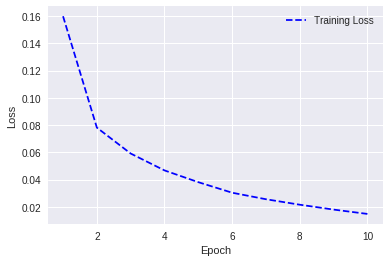

In [0]:
epochs = 10
# epochs = 20      # Only if you can wait
learning_rate = 0.001

loss_fn = N.NLLLoss()
optimizer = O.Adam(wordseg_model.parameters(), lr=learning_rate)
train_model(wordseg_model, training_set, epochs, loss_fn, optimizer)

-----

### Trying out

In [0]:
def tokenize(wordseg_model, charseq):
    charidxs = str2idxseq(charseq)
    pred_brkvecs = wordseg_model(charidxs)
    pred_wordbrks = []
    for i in range(len(charidxs)):
        pred_wordbrk = (pred_brkvecs[i][0] > pred_brkvecs[i][1])
        # print(pred_wordbrk)
        pred_wordbrks.append(pred_wordbrk)
    
    sent = []
    word = []
    begpos = 0
    for i in range(len(pred_wordbrks)):
        if pred_wordbrks[i]:
            word.append(charseq[i])
            sent.append(word)
            word = []
            begpos = i
        else:
            word.append(charseq[i])
    if len(word) > 0: sent.append(word)
        
    return sent

In [0]:
words = tokenize(wordseg_model, 'tobe,ornottobe,thatisthequestion.')
print(' '.join(''.join(word) for word in words))

to be , or not to be , that is the question .


-------

### Testing Procedure

Let's test our model and how much accuracy we can achieve.

In [0]:
def test_model(wordseg_model, testing_data):
    no_correct = 0.0
    no_goldbrks = 0.0
    no_predbrks = 0.0

    for (charidxs, gold_wordbrks) in tqdm(testing_data):
        pred_brkvecs = wordseg_model(charidxs)
        pred_wordbrks = []
        for i in range(len(charidxs)):
            pred_wordbrk = (pred_brkvecs[i][0] > pred_brkvecs[i][1])
            pred_wordbrks.append(pred_wordbrk)
        
        for i in range(len(charidxs)):
            if gold_wordbrks[i] and gold_wordbrks[i] == pred_wordbrks[i]:
                no_correct += 1.0
            if gold_wordbrks[i]:
                no_goldbrks += 1.0
            if pred_wordbrks[i]:
                no_predbrks += 1.0

    precision = 100 * no_correct / no_predbrks
    recall = 100 * no_correct / no_goldbrks
    f1 = 2 * precision * recall / (precision + recall)
    
    print('\nPrecision = {}'.format(precision))
    print('Recall = {}'.format(recall))
    print('F1 = {}'.format(f1))

In [0]:
test_model(wordseg_model, testing_set)

100%|██████████| 622/622 [00:16<00:00, 38.26it/s]


Precision = 94.6896252351324
Recall = 95.03340110368865
F1 = 94.86120171051677


## Exercises

Vary the dimension of character vectors, the dimension of internal states, and the number of RNN layers. Observe the change of F1 scores.

<font color="red">**PLEASE NOTE THAT ONLINE TRAINING IS TIME-CONSUMING.**</font>

In [0]:
# for dim_charvec in [4, 8, 16, 32, 64]:
#     for dim_trans in [4, 8, 16, 32, 64]:
#         for no_layers in [1, 2, 3]:
#             print('>>> dim_charvec={}  dim_trans={}  no_layers={}'.format(dim_charvec, dim_trans, no_layers))
#             wordseg_model_ex1 = WordsegModel(dim_charvec, dim_trans, no_layers)
#             train_model(wordseg_model_ex1, training_set, epochs, loss_fn, optimizer)
#             test_model(wordseg_model_ex1, testing_set)